In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
tf.keras.callbacks

<module 'tensorflow._api.v1.keras.callbacks' from 'C:\\Users\\mubashar.nazar\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\tensorflow\\_api\\v1\\keras\\callbacks\\__init__.py'>

In [59]:
#data reading
data = pd.read_csv("./train.csv", sep=",")

In [62]:
#splitting examples and labels
X = data.iloc[:,1:]
Y = data.iloc[:,0]

In [63]:
#convert dataframe into a ndarray
X = X.as_matrix().reshape([X.shape[0], 28,28])

C:\Users\mubashar.nazar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [132]:
#reshaping 2d examples in 3D
X = X.reshape(X.shape[0], 28, 28, 1)

In [104]:
#onehot encoding
Y = pd.get_dummies(Y)

In [142]:
#train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

# tensorFlow

In [148]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    
    X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0], name="x")
    Y = tf.placeholder(tf.float32, shape=[None, n_y], name="y")
    
    return X, Y

In [149]:
def initialize_parameters():

    tf.set_random_seed(1)                              # so that your "random" numbers match ours

    W1 = tf.get_variable("W1", [4,4,1,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [150]:
def forward_propagation(X, parameters, outputs):
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    print (X.shape)
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="SAME")
    print (Z1.shape)
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding="SAME")
    print (P1.shape)
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding="SAME")
    print (Z2.shape)
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding="SAME")
    print (P2.shape)
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    print (P2.shape)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 10 neurons in output layer.
    Z3 = tf.contrib.layers.fully_connected(P2, outputs, activation_fn=None)
    print (Z3.shape)

    return Z3

In [151]:
def compute_cost(Z3, Y):

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost

In [158]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.01,
          num_epochs = 1000, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters, len(Y_train.columns))
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name="optimizer").minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            
            seed = seed + 1
              
            _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:X_train, Y:Y_train})
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, temp_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(temp_cost)
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        tf.add_to_collection("predict_op", predict_op)
        
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
#         print(accuracy)
        
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        saver.save(sess, save_path="graph")
    
        return train_accuracy, test_accuracy, parameters

(?, 28, 28, 1)
(?, 28, 28, 8)
(?, 4, 4, 8)
(?, 4, 4, 16)
(?, 1, 1, 16)
(?, 16)
(?, 10)
Cost after epoch 0: 226.943893
Cost after epoch 5: 41.436584
Cost after epoch 10: 13.325080
Cost after epoch 15: 6.645814
Cost after epoch 20: 4.278826
Cost after epoch 25: 3.050441
Cost after epoch 30: 2.679555
Cost after epoch 35: 2.461791
Cost after epoch 40: 2.366124
Cost after epoch 45: 2.303601
Cost after epoch 50: 2.257425
Cost after epoch 55: 2.222624
Cost after epoch 60: 2.188486
Cost after epoch 65: 2.154454
Cost after epoch 70: 2.119947
Cost after epoch 75: 2.087211
Cost after epoch 80: 2.053699
Cost after epoch 85: 2.022174
Cost after epoch 90: 1.992800
Cost after epoch 95: 1.966807
Cost after epoch 100: 1.941885
Cost after epoch 105: 1.916685
Cost after epoch 110: 1.891867
Cost after epoch 115: 1.868026
Cost after epoch 120: 1.845291
Cost after epoch 125: 1.823341
Cost after epoch 130: 1.801984
Cost after epoch 135: 1.780913
Cost after epoch 140: 1.759647
Cost after epoch 145: 1.738025
C

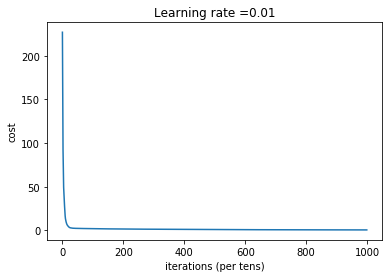

Train Accuracy: 0.8350794
Test Accuracy: 0.8290476


In [159]:
_, _, parameters = model(x_train, y_train, x_test, y_test)

# testing

In [173]:
test = pd.read_csv("./test.csv", sep=",")
test = test.as_matrix().reshape([test.shape[0], 28,28])
test = test.reshape(test.shape[0], 28, 28, 1)

C:\Users\mubashar.nazar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [183]:
def save():
    G = tf.Graph()
    result = []
    with tf.Session(graph=G) as sess:
        new_saver = tf.train.import_meta_graph('graph.meta')
        new_saver.restore(sess, 'graph')
        predict_op = tf.get_collection("predict_op")[0]

        X = G.get_operation_by_name("x").outputs[0]
        p = sess.run([predict_op], feed_dict={X: test})
        print (p)
        return p

In [184]:
testData = save()

INFO:tensorflow:Restoring parameters from graph
[array([2, 0, 9, ..., 3, 4, 2], dtype=int64)]


In [192]:
submission = pd.read_csv('./submission.csv')
submission['Label'] = testData[0]
submission.to_csv('submission.csv', index=False)